#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Анализ-общей-информации" data-toc-modified-id="Анализ-общей-информации-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ общей информации</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Прототипирование" data-toc-modified-id="Прототипирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Прототипирование</a></span><ul class="toc-item"><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Базовые-модели" data-toc-modified-id="Базовые-модели-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Базовые модели</a></span></li><li><span><a href="#Настройка-гиперпараметров" data-toc-modified-id="Настройка-гиперпараметров-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Настройка гиперпараметров</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание проекта

**Заказчик**: Компания «Чётенькое такси»

**Дано**: Исторические данные о заказах такси в аэропортах 

**Описание данных**: Количество заказов находится в столбце `num_orders`

**Бизнес-цель**: Привлекать больше водителей в период пиковой нагрузки   

**Задача**: Построить модель для предсказания количества заказов такси на следующий час  

**Base-line**: Значение метрики RMSE на тестовой выборке <= 48

## Анализ общей информации

Импортируем библиотеки, с помощью которых будем обрабатывать данные

In [1]:
# Работа с данными
import pandas as pd 
import numpy as np
import time
from collections import defaultdict
from statsmodels.tsa.seasonal import seasonal_decompose

# Модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

#Метрики
from sklearn.metrics import mean_squared_error, make_scorer

# Подбор гиперпараметров и лучшей модели
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Визуализация данных
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Игнорирование предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')

SEED = 42

Блок самописных функций используемых в проекте

In [2]:
# Класс по добавлению признаков
class MakeFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 max_lag,
                 rolling_mean_size,
                 target,
                 dayofweek=True,
                 hour=True):
        
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.dayofweek = dayofweek
        self.hour=hour
        self.target =target
        
        self.lag_ = defaultdict()
        
      
        
    def fit(self, X, y=None):
        
        self.X_ = X.drop(columns=self.target)
        self.y_ = X[self.target]
        
        return self
            
    
    
    def transform(self, X):

        temp = X.copy()
        
       
        for l in range(self.max_lag):
            temp['lag_'+str(l)] = temp[self.target].shift(l+1)
            
        temp['rolling_mean'] = temp[self.target].shift().rolling(self.rolling_mean_size).mean()
        
        
        if self.dayofweek:
            temp['dayofweek'] = X.index.dayofweek
        if self.hour:
            temp['hour'] = X.index.hour
            
        for l in  range(self.max_lag+1):
            temp.iloc[:l+1, l] = self.y_[-l-1:].values.T

        temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \
        self.y_[-self.rolling_mean_size:].values.T
        
        temp = temp.drop(columns=self.target)

        return temp
    
# Функция расчета метрики root mean squared error
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred)**0.5, 2)

rmse_score = make_scorer(rmse, greater_is_better=False)

   
# Функция для возможности запуска нескольких базовых моделей 
def Model(features_train, target_train, features_test, target_test, model_info):
           
    model = model_info[0].fit(features_train, target_train)
    predict_train = model.predict(features_train)
    rmse_train = rmse(target_train, predict_train)
    predict = model.predict(features_test)
    rmse_result = rmse(target_test, predict)
    lst_results = [model_info[1], rmse_train, rmse_result]    
    
    return lst_results

# Функцию для запуска функции Model в цикле 
def start_model(features_train, target_train, features_test, target_test, model_list):
    
    table_models = []
    for model_info in model_list:
        start_time = time.time()
        lst_model = Model(features_train, target_train, features_test, target_test, model_info)
        time_model = round((time.time() - start_time),2)
        lst_model.append(time_model)
        table_models.append(lst_model)
        
    df_m = pd.DataFrame(data=table_models, columns=['model', '1_rmse_train', '2_rmse_test', 'time_model'])
    table = df_m.pivot_table(values=['1_rmse_train', '2_rmse_test', 'time_model'],    
                             index=['model'])
    
    return table 

Прочитаем данные и запишем в переменную df

In [3]:
name = 'taxi.csv'

try: 
    df = pd.read_csv('datasets\\{}'.format(name), parse_dates=[0], index_col=[0])
except:
    print(print('Файл {} не найден и будет скачиваться по сети.'.format(name)))
    df = pd.read_csv('https://code.s3.yandex.net/datasets/{}'.format(name), parse_dates=[0], index_col=[0])    

Файл taxi.csv не найден и будет скачиваться по сети.
None


Используем метод info для определения типов данных признаков

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем данные по индексу и проверим в хронологическом ли порядке расположены даты и время

In [5]:
df = df.sort_index()
print(df.index.is_monotonic)

True


Поменяем интервал временного ряда, сделаем его равным 1 часу

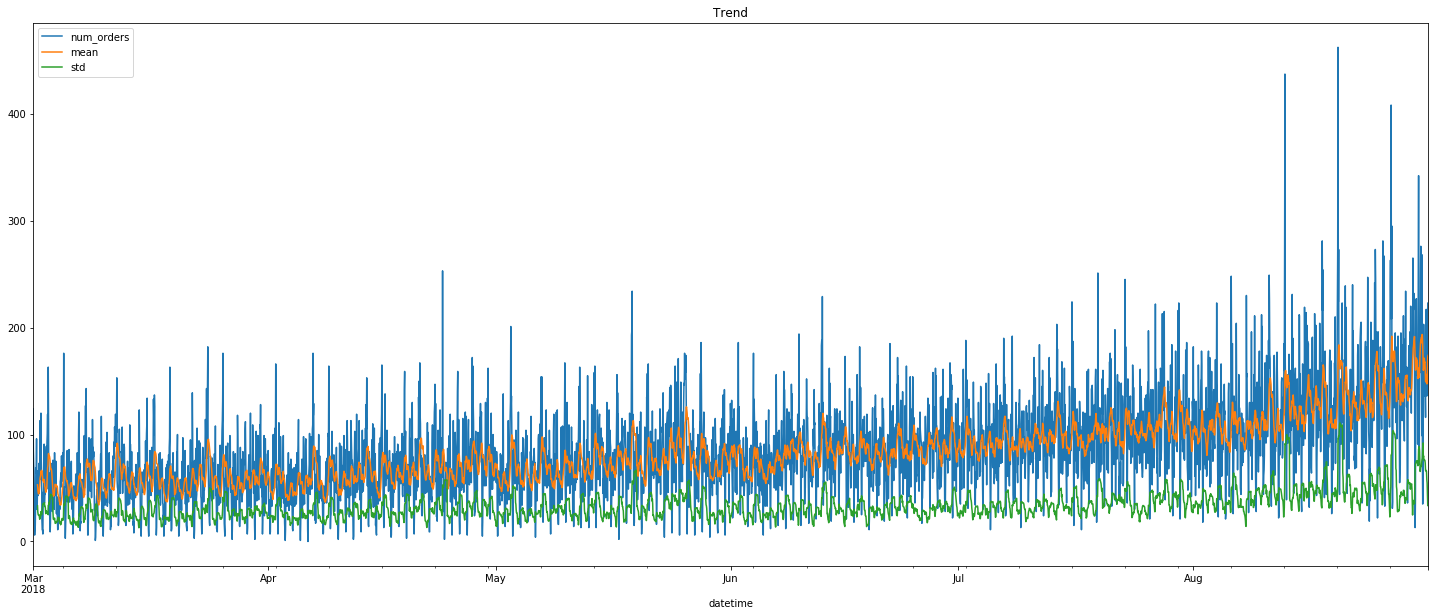

In [6]:
df = df.resample('1H').sum()
data_with_mean_std = df.copy()
data_with_mean_std['mean'] = df['num_orders'].rolling(15).mean()
data_with_mean_std['std'] = df['num_orders'].rolling(15).std()
data_with_mean_std.plot(figsize=(25,10), title='Trend')

На графике мы видим нестационарный временной ряд, т.к. его среднее и стандартное отклонение меняются.

Разложим временной ряд на тренд, сезонную компоненту и остатки

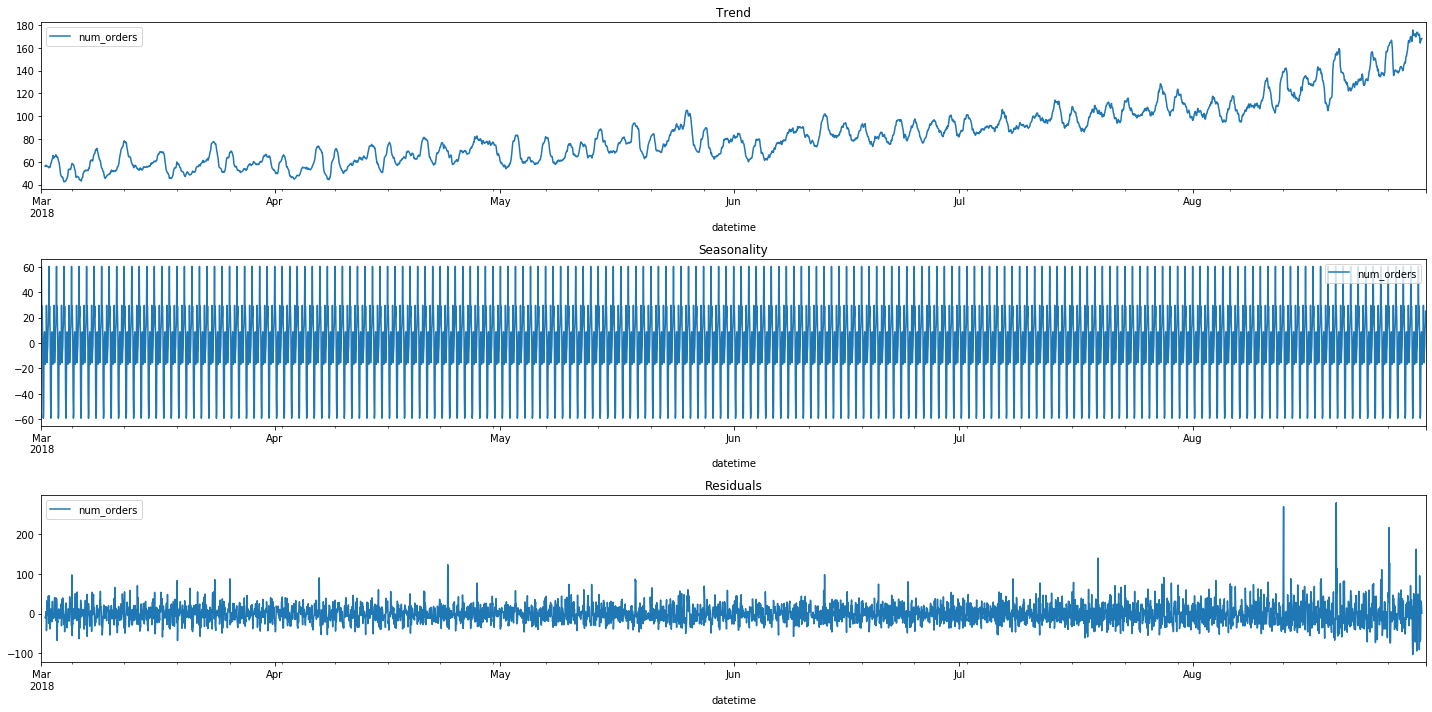

In [7]:
decomposed = seasonal_decompose(df)
plt.figure()
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики перегружены, рассмотрим данные за один месяц

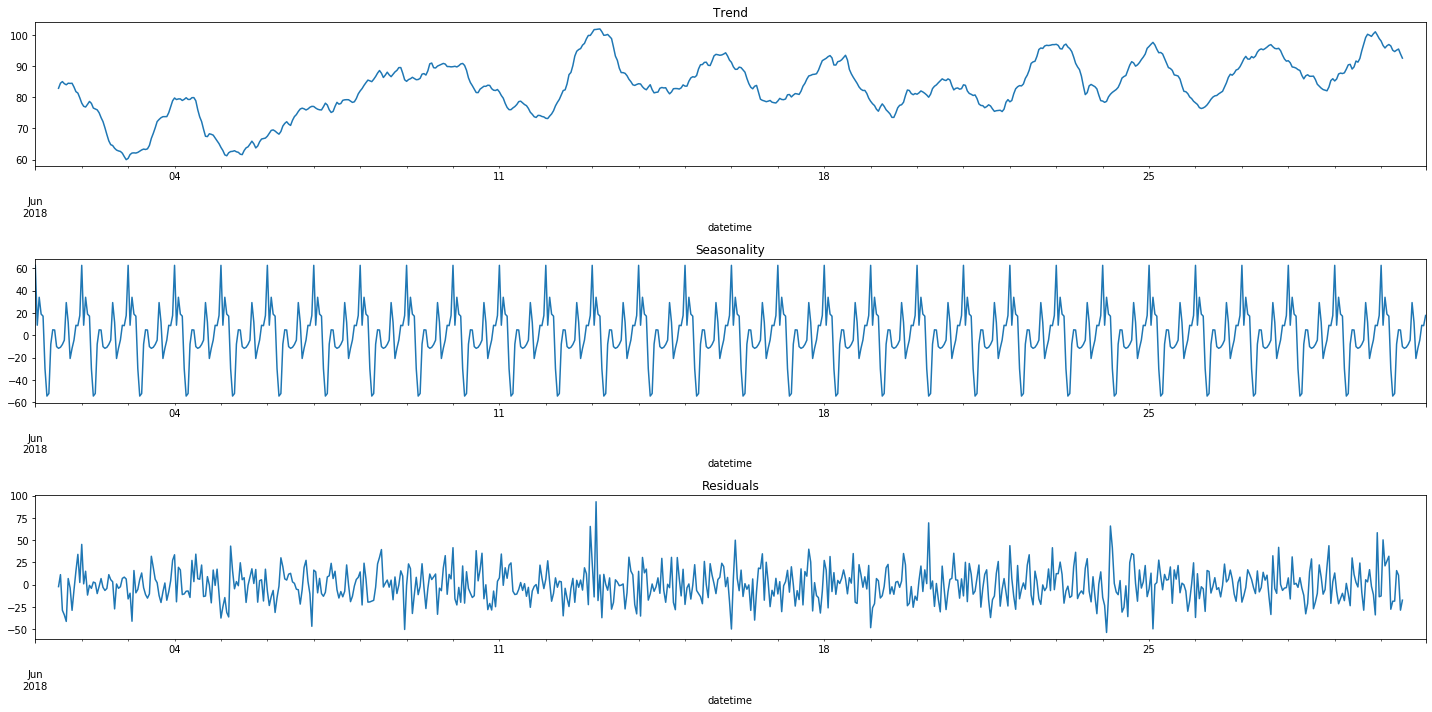

In [8]:
decomposed_june= seasonal_decompose(df['2018-06':'2018-06']['num_orders'])
plt.subplot(311)
decomposed_june.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_june.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_june.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Рассмотрим данные за первую неделю июня

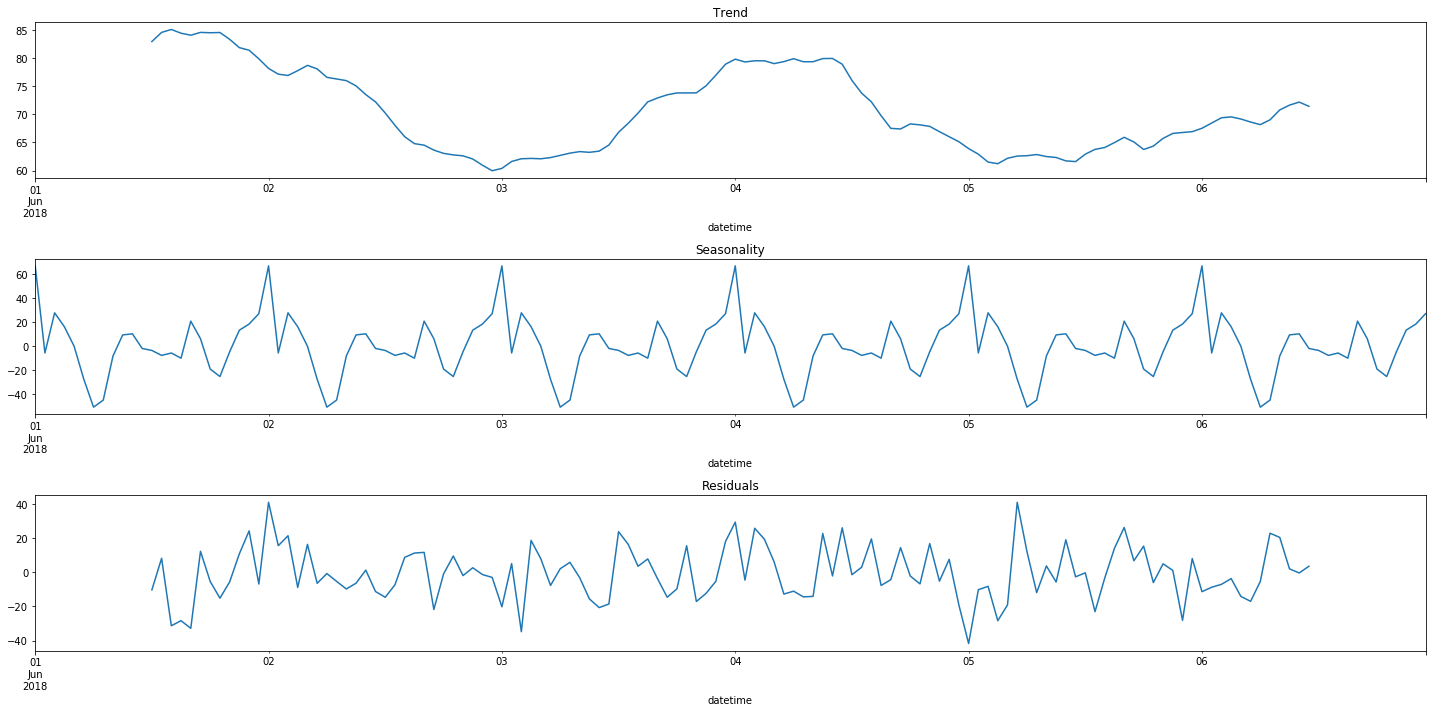

In [9]:
decomposed_june= seasonal_decompose(df['2018-06-01':'2018-06-06']['num_orders'])
plt.subplot(311)
decomposed_june.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_june.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_june.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод**

В результате анализа данных и декомпозиции временного ряда на составляющие выяснено, что данные имеют явный тренд, среднее количество заказов увеличивается с течением времени. Так же в данных наблюдается сезонность в зависимости от времени суток.

## Предобработка данных

Применим предобработку к данным вызвав функцию MakeFeatures

In [10]:
maker = MakeFeatures(24, 2, 'num_orders')

X = df
y = df['num_orders']

X = maker.fit_transform(X)

Поделим данные на обучающую и тестовую выборки

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

print('Размер обучающего набора данных: ', X_train.shape)
print('Размер тренировочного набора данных: ', X_test.shape)

print('Границы временного диапозона тренировочного набора данных: ' ,X_train.index.min(), X_train.index.max())
print('Границы временного диапозона тестового набора данных: ' ,X_test.index.min(), X_test.index.max())

Размер обучающего набора данных:  (3974, 27)
Размер тренировочного набора данных:  (442, 27)
Границы временного диапозона тренировочного набора данных:  2018-03-01 00:00:00 2018-08-13 13:00:00
Границы временного диапозона тестового набора данных:  2018-08-13 14:00:00 2018-08-31 23:00:00


**Вывод**

Реализован класс для формирования новых признаков на основании выявленных особенностей в данных. Для проверки базовых моделей выбран лаг 24 - что отражает суточную сезонность. Далее лаг будет подбираться. 

## Прототипирование

### Константная модель

Запуск константной модели для возможности проверки последующих моделей на адекватность. Предсказание - медиана обучающей выборки

In [12]:
# Инициализируем и обучаем модель
model_const = DummyRegressor(strategy="median")
model_const.fit(X_train, y_train)

# Получаем предсказания на тестовой выборке
predict_const = model_const.predict(X_test)

# Проверяем метрику получившейся модели
rmse_const = rmse(y_test, predict_const)
print('RMSE константной модели на тестовой выборке:', rmse_const)

RMSE константной модели на тестовой выборке: 87.15


### Базовые модели

Осуществим вызов функции start_model для запуска базовых моделей

In [13]:
model_list = [[LinearRegression(), 'LinearRegression'],
              [Ridge(random_state=SEED), 'Ridge'], 
              [Lasso(random_state=SEED), 'Lasso'],
              [XGBRegressor(), 'XGBRegressor'],
              [LGBMRegressor(boosting_type='gbdt', random_state=SEED), 'LGBMRegressor']]

result = start_model(X_train, y_train, X_test, y_test, model_list)
result.sort_values(by='2_rmse_test', ascending=True)

[08:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,1_rmse_train,2_rmse_test,time_model
model,,,
LGBMRegressor,12.48,45.02,0.36
Lasso,26.30,45.49,0.22
LinearRegression,26.28,45.49,0.03
Ridge,26.28,45.49,0.18
XGBRegressor,20.15,49.28,0.49


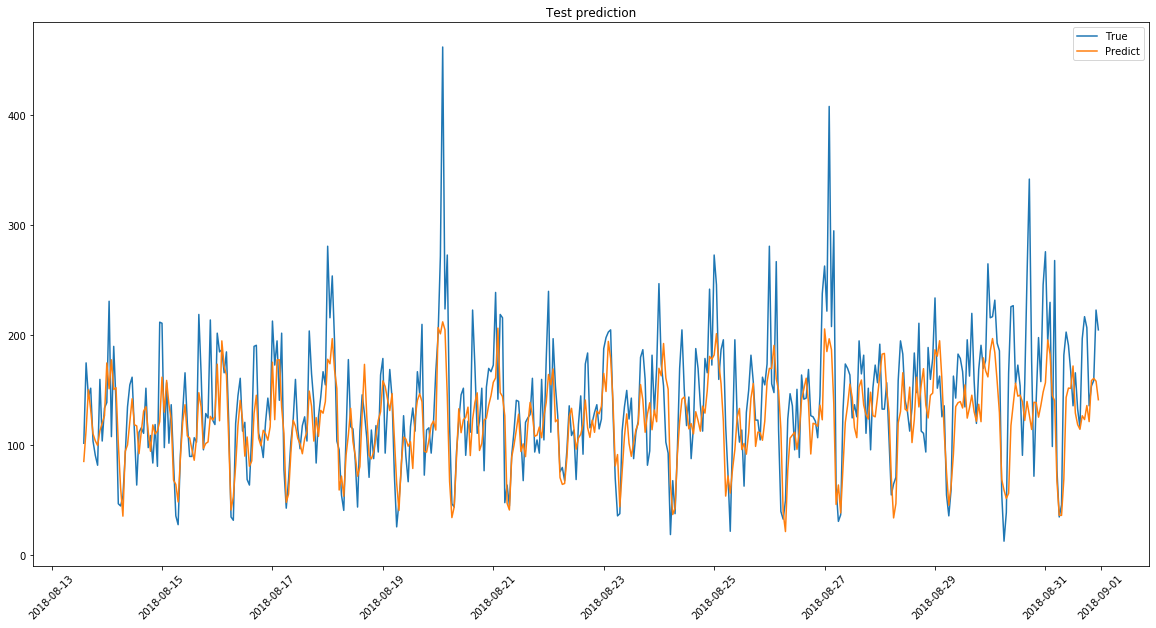

In [14]:
# Визуализируем предсказание лучшей модели и реальные данные  
model = LGBMRegressor(boosting_type='gbdt', random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')
plt.xticks(rotation=45)
plt.title('Test prediction')
plt.legend()
plt.show()

### Настройка гиперпараметров

Сформируем пайплайн

In [15]:
# Поделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df, df['num_orders'], shuffle=False, test_size=0.1)

In [16]:
pipe = Pipeline([
    ('maker', MakeFeatures(24, 2, 'num_orders')),
    ('model', LGBMRegressor(boosting_type='gbdt', random_state=SEED, num_leaves=21))
])

params = [{
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [Lasso(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 5)
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [Ridge(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 5)
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LinearRegression()],
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=SEED, num_leaves=21)],
        'model__num_leaves': [20, 31, 40],
        'model__max_depth': [-1, 10, 20],
        'model__learning_rate': [0.08, 0.1, 0.12]
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [XGBRegressor(random_state=SEED)],
        'model__max_depth': [6, 11],
        'model__learning_rate': [0.015, 0.5]
    }
]

Запустим GridSearchCV

In [17]:
cv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(pipe, param_grid=params, scoring=rmse_score, cv=cv, verbose=False)
grid = grid.fit(X_train, y_train)

[09:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Сгруппируем результаты GridSearchCV в таблицу

In [18]:
grid_results = pd.DataFrame(grid.cv_results_)
models = ['Lasso', 'Ridge', 'LinearRegression', 'LGBMRegressor', 'XGBRegressor']
cols = ['mean_fit_time', 'mean_score_time', 'mean_test_score']
res = pd.DataFrame(columns=cols)

for model in models:
    model_idx = grid_results['param_model'].astype('str').str.contains(model)
    best_fit = abs(grid_results[model_idx].sort_values(by='rank_test_score').head(1)[cols])
    res = res.append(best_fit)
    res.loc[best_fit.index, 'model'] = model
    
res.sort_values(by='mean_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,model
39,0.508608,0.364492,23.53875,Lasso
264,1.201450,0.208775,23.71000,LGBMRegressor
76,0.392918,0.355716,24.19500,Ridge
96,0.527600,0.357049,24.19500,LinearRegression
364,0.683280,0.060503,26.54500,XGBRegressor


Проверим лучшую модель на тестовом наборе данных

In [19]:
model = grid.best_estimator_
    
y_pred = model.predict(X_test)
print('RMSE на тестовом наборе данных:', rmse(y_test, y_pred))

RMSE на тестовом наборе данных: 38.57


Визуализируем предсказание лучшей модели и реальные данные

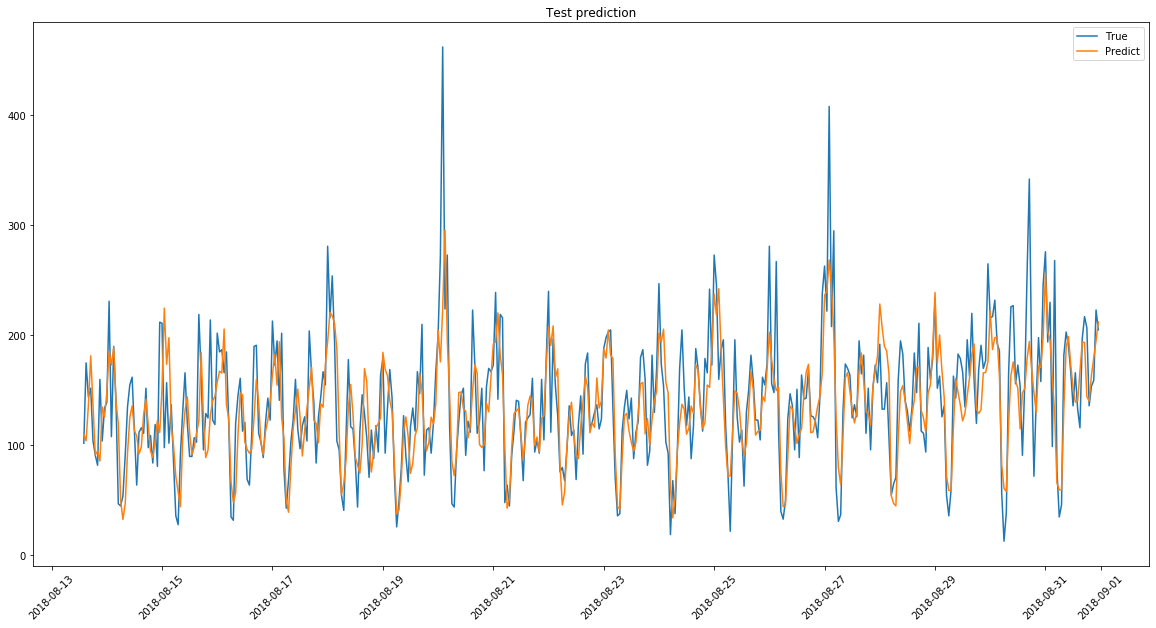

In [20]:
plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')
plt.xticks(rotation=45)
plt.title('Test prediction')
plt.legend()
plt.show()

**Вывод**

Проверены базовые модели Lasso, Ridge, LinearRegression, LGBMRegressor, XGBRegressor.  
Для всех моделей произведен подбор параметров.  
Лучшие значения продемонстрировала модель Lasso.  

## Общий вывод

Анализ данных показал, что в данных отсутствуют пропуски и в датах присутствует монотонность периодов.   
Временной ряд нестационарен, с выраженным восходящим трендом и наличием сезонности (часовая, суточная, недельная).  
Т.к. данные предоставлены менее чем за один год, то сложно выявить причины появления тренда - принято решение не применять методы по его корректировке.  
Данные семплированы с периодичностью 1 час. Создана функция по генерации дополнительных признаков - отражение информации на основе даты (час, день, неделя, месяц), лаги разной длины и сглаживание (был произведен подбор оптимальных значений).  
В качестве первоначального шага были построены модели Lasso, Ridge, LinearRegression, LGBMRegressor, XGBRegressor с настройками по умолчанию. Выявлена закономерность, что на обучающих наборах данных лучшее качество продемонстрировали модели с бустингом, а на тестовом наборе данных - линейные.  
Следующим шагом был подбор оптимальных параметров для всех моделей.  
По результату лучшие результаты продемонстрировала линейная модель Lasso.  
Значение метрики RMSE на тестовом наборе данных: 38.57, что ниже, чем требуемый порог - 48.   
Так же для проверки моделей построена константная модель. Значение метрики константной модели 87.15, что подтверждает адекватность победившей модели.